In [1]:
import libmoon
from libmoon.solver.gradient.methods import EPOSolver
from libmoon.util.synthetic import synthetic_init
from libmoon.util.prefs import get_uniform_pref
from libmoon.util import get_problem


In [2]:
import torch, numpy as np, matplotlib.pyplot as plt

# Device/dtype config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_FP32_ON_GPU =True  
DTYPE = torch.float32 if (DEVICE.type == "cuda" and USE_FP32_ON_GPU) else torch.float64

torch.set_default_dtype(DTYPE)
torch.manual_seed(0); np.random.seed(0)


IT_NEWTON = 60
TOL_NEWTON = 1e-12 if DTYPE == torch.float64 else 1e-8


def abs_smooth(z, eps=1e-12):
    return torch.sqrt(z*z + eps)


class XssNewton(torch.autograd.Function):
    @staticmethod
    def forward(ctx, alpha, n, it=60, tol=1e-12):
        x = torch.ones_like(alpha)
        for _ in range(it):
            g   = alpha / (1 + x.pow(n)) - x
            g_x = -1 - alpha*n*x.pow(n-1)/(1 + x.pow(n)).pow(2)
            step = g / g_x
            x = (x - step).clamp_min(1e-9)
            if torch.max(torch.abs(step)) < tol:
                break
        ctx.save_for_backward(x, alpha, n)
        return x

    @staticmethod
    def backward(ctx, grad_out):
        x, alpha, n = ctx.saved_tensors
        g_x = -1 - alpha*n*x.pow(n-1)/(1 + x.pow(n)).pow(2)
        g_a = 1/(1 + x.pow(n))
        g_n = -alpha*x.pow(n)*torch.log(x.clamp_min(1e-12))/(1 + x.pow(n)).pow(2)
        coeff = -grad_out/g_x
        return coeff*g_a, coeff*g_n, None, None, None


In [3]:
from libmoon.problem.synthetic.mop import BaseMOP
class SensitivityMOP(BaseMOP):
    def __init__(self, eps=1e-8):
        super().__init__(n_var=2, n_obj=2, n_cons=0)
        self.problem_name = "ZDT1"
        self.n_dim = self.n_var = 2
        self.n_obj = 2
        self.lbound = torch.tensor([0.001, 0.001], dtype=DTYPE, device=DEVICE)
        self.ubound = torch.tensor([50.0 , 10.0], dtype=DTYPE, device=DEVICE)
        self.eps = float(eps)

    def _evaluate_torch(self, z: torch.Tensor) -> torch.Tensor:
        lb = self.lbound
        ub = self.ubound
        alpha = z[:,0].clamp(lb[0], ub[0])
        n     = z[:,1].clamp(lb[1], ub[1])
        x     = XssNewton.apply(alpha, n, IT_NEWTON, TOL_NEWTON)
        f1 = abs_smooth(alpha*(1+x.pow(n)) /
               (x + alpha*n*x.pow(n)+2*x.pow(1+n)+x.pow(1+2*n)), self.eps)
        num2 = alpha*n*torch.log(x.clamp_min(1e-12))*x.pow(n-1)
        den2 = 1 + alpha*n*x.pow(n-1) + 2*x.pow(n) + x.pow(2*n)
        f2 = abs_smooth(-num2/den2, self.eps)
        return torch.stack([f1, f2], dim=1)


In [6]:
from libmoon.solver.gradient.methods import EPOSolver
from libmoon.util.prefs import get_uniform_pref

problem = SensitivityMOP()

K = 5000

eps_pref = 1e-4
t = torch.linspace(eps_pref, 1 - eps_pref, steps=K, dtype=DTYPE, device=DEVICE)
prefs = torch.stack([t, 1 - t], dim=1)

lb, ub = problem.lbound, problem.ubound

sobol = torch.quasirandom.SobolEngine(dimension=2, scramble=True)

xu = sobol.draw(K).to(dtype=DTYPE, device=DEVICE)
x0 = lb + xu * (ub - lb)

solver = EPOSolver(
    step_size=5e-4,
    n_epoch=50,
    tol=1e-5,
    problem=problem,
    prefs=prefs,
)

res = solver.solve(x_init=x0)


100%|██████████| 50/50 [22:59<00:00, 27.59s/it]


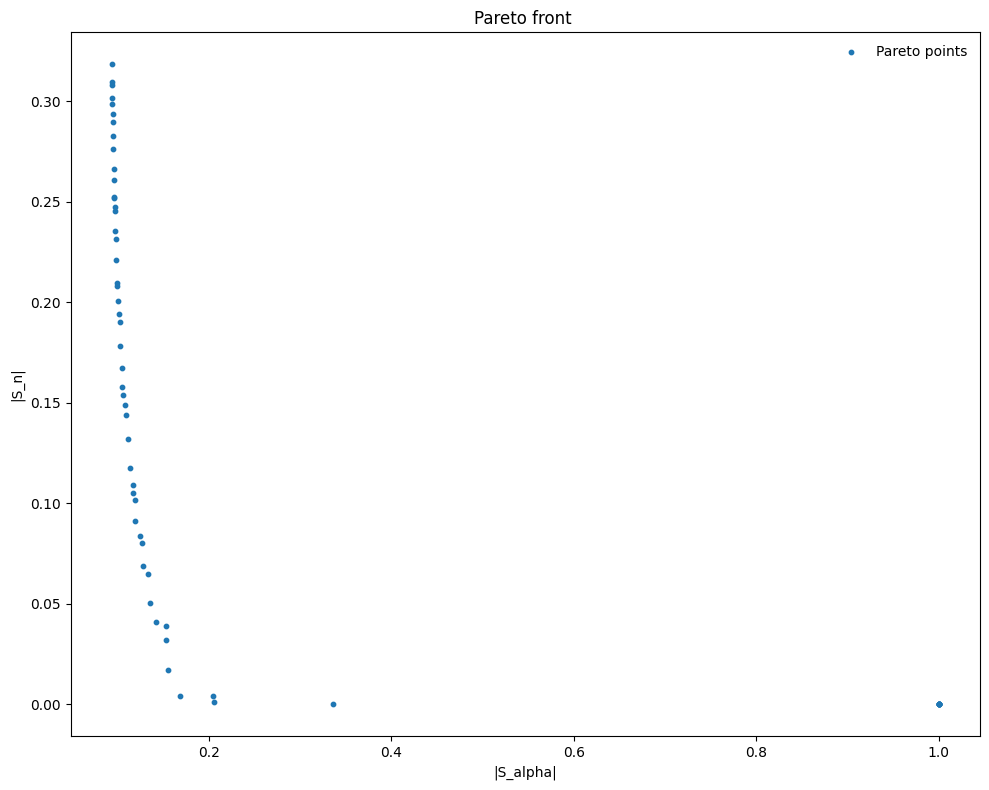

In [7]:
X = res["x"]
Y = res["y"]


if torch.is_tensor(Y):
    Y_np = Y.detach().cpu().numpy()
else:
    Y_np = np.asarray(Y)


Y_pf = None

from paretoset import paretoset
mask = paretoset(Y_np, sense=["min", "min"])  # both objectives minimized
Y_pf = Y_np[mask]

import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.scatter(Y_pf[:, 0], Y_pf[:, 1], s=10, label="Pareto points")
plt.xlabel("|S_alpha|")
plt.ylabel("|S_n|")
plt.title("Pareto front ")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


z_new = z_old - learning_rate * [ p1 * ∇f1(z) + p2 * ∇f2(z) ]
z = (alpha, n)

You generate K preference vectors (prefs). Each vector, like [0.9, 0.1] or [0.5, 0.5], tells the optimizer how to weight the two objectives. A preference of [0.9, 0.1] means "I care 90% about minimizing f1 and 10% about minimizing f2".

You use the EPO (Equilibrium Policy Optimization) solver. For each initial guess and its corresponding preference vector, EPO performs gradient descent. It calculates the gradients of the two objectives and uses the preference to decide the direction to move in the variable space (alpha, n) that best satisfies that specific preference.

The step_size (learning rate) controls the size of each update step.

Result: After optimization, you have K solutions. Each solution is a pair (alpha, n) that is optimal for a specific trade-off between f1 and f2.

I am mapping the Pareto front for two competing sensitivity functions. I start by generating a diverse set of 2000 initial points in the design variable space. Then, I use solver (EPO) to optimize these points. The solver uses a set of preference directions to find solutions that represent optimal trade-offs between minimizing the two sensitivities. Finally, I extract the non-dominated solutions from these results to plot the Pareto front, which shows the best achievable compromises between |S_alpha| and |S_n|.

# What this notebook is doing (simple explanation)

- We choose two design knobs: alpha and n. For each pair (alpha, n), we compute a steady-state value x by solving one equation with Newton's method. This inner solve is made differentiable so gradients can flow through it.
- From x we compute two numbers (objectives): f1 and f2. Smaller is better for both.
- A Pareto point is one where you can’t make f1 smaller without making f2 bigger (and vice versa).
- We generate many “preferences” (weights) that say how much we care about f1 vs f2. For each preference, our solver nudges (alpha, n) in a direction that improves both objectives according to that trade‑off.
- Doing this for lots of preferences traces out the whole Pareto front. Then we keep only the non‑dominated points and plot them.

Why it sometimes looks jagged and how we fixed it:
- Randomness and big steps cause tiny zig‑zags. We switched to evenly‑spaced preferences, smaller steps, more epochs, double precision, and a tighter inner Newton solve. We also add a small visual smoothing line to make the plotted curve look cleaner without changing the actual solutions.


# High-level algorithm breakdown

## Big picture
- Goal: find all no-regret designs for two objectives f1 and f2 (minimize both).
- A Pareto point is one you can’t improve in f1 without worsening f2.
- We sweep trade-offs (preferences) and do small gradient steps that respect each trade-off to trace the front.

## Building blocks
- Design variables: (alpha, n).
- Inner solve: for each (alpha, n), compute steady-state x via differentiable Newton.
- Objectives: compute f1(alpha, n, x) and f2(alpha, n, x).

## Covering trade-offs
- Generate K preference weights (w1, w2) with w1 + w2 = 1, evenly spaced from f1-focus to f2-focus.
- Initialize K candidates across the bounds (Sobol) to cover the space.

## Optimization loop (per epoch)
1) Evaluate f = [f1, f2] and gradients w.r.t. (alpha, n) for all K candidates.
2) Use EPO (Efficient Pareto Optimization) to choose a convex combination of objective gradients per preference that yields a fair descent direction.
3) Take a small step in (alpha, n) along that direction and project back into bounds.
4) Repeat until steps are tiny or the epoch limit is reached.

## Extracting the Pareto front
- After training, collect all objective pairs Y.
- Select the non-dominated subset (Pareto points) using a Pareto extractor (paretoset/pymoo), then plot.

## Why this recovers the curve
- Evenly spaced preferences cover extremes and the middle.
- EPO directions respect the current trade-off, so nearby preferences land on nearby front points.
- Stable numerics (double precision, tight Newton, careful step sizes) reduce jaggedness.

## What each part contributes
- Newton layer: fast, differentiable steady-state x → smooth objectives.
- EPO step: principled multi-objective descent that avoids one objective dominating.
- Non-dominated selection: keeps only truly optimal trade-offs for plotting.
